<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


In [2]:
# Если удобнее в колабе, то ссылка вот:
# https://colab.research.google.com/drive/1hcZc1Ng11UtexR9TAGmNyQzKaRAZl9o9?usp=sharing

# Vanilla Autoencoder

In [1]:
from google.colab import drive

from tqdm import tqdm, tqdm_notebook
from time import time

import PIL
from PIL import Image
from skimage.io import imread

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer

In [2]:
from torchvision import datasets

import torch
from torch.nn import functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np

%matplotlib inline

In [3]:
# Проверяем нличие гпу
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# Устанавливаем девайс
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

CUDA is available!  Training on GPU ...


In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled"):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    photo_paths = df['photo_path']

    # all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return photo_paths.values, all_attrs


# Датасет
class autoencoder_dataset(Dataset):
    """
    Датасет с картинками
    """
    # Получаем на вход список путей к картинками и результатам сегментации
    def __init__(self, photo_paths, input_size=90, d=64):
        super().__init__()
        self.d = d
        self.input_size = input_size
        self.photo_paths = photo_paths
        self.len_ = len(self.photo_paths)

    def load_sample(self, path):
        image = imread(path)
        image = image[self.d:-self.d,self.d:-self.d]
        image = Image.fromarray(image)
        return image
                      
    def __len__(self):
        return self.len_
  
    def __getitem__(self, index):
        # Перевод в нужный размер и в тензоры
        transform = transforms.Compose([
            transforms.Resize(size=(self.input_size, self.input_size)),
            transforms.ToTensor()
            ])
        
        image = self.load_sample(self.photo_paths[index])
        image = transform(image)

        return image

In [ ]:
dim_code = 128

def dim_layer(input, kernel_size, stride):
    out = ((input - kernel_size) // stride) + 1
    return out

out = 90
for i in range(3):
    out = dim_layer(out, 4, 2)
    print(out)
print(out*out*128)

44
21
9
10368


In [ ]:
class Autoencoder_v2(nn.Module):
    def __init__(self, out_dim=256*10**2, latent_dim=512):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, padding_mode='replicate'),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, dilation=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, padding_mode='replicate'),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, padding_mode='replicate'),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(out_dim, out_dim // 16),
            nn.ReLU(),
        )
        
        self.fc_latent = nn.Linear(out_dim // 16, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, out_dim // 16),
            nn.ReLU(),
            nn.Linear(out_dim // 16, out_dim),
            nn.ReLU(),
            nn.Unflatten(1, (256, 10, 10) ),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, dilation=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=1),
            nn.Sigmoid()
        )

    def _decoder(self, x):
        z = self.decoder(x)
        return z
        
    def forward(self, x):
        # encoder
        x = self.encoder(x)

        # latent
        latent_code = self.fc_latent(x)
        
        # decoder
        reconstruction = self.decoder(latent_code)        
        return reconstruction, latent_code

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    loss_avg = 0
  
    for inputs in train_loader:
        inputs = inputs.to(DEVICE)

        reconstruction, latent_code = model(inputs)
        loss = criterion(reconstruction, inputs)
        loss.backward()
        optimizer.step()

        loss_avg += loss.item()
        optimizer.zero_grad()

    train_loss = loss_avg / len(train_loader)
    return train_loss

def eval_epoch(model, val_loader, criterion):
    model.eval()
    loss_avg = 0

    for inputs in val_loader:
        inputs = inputs.to(DEVICE)

        with torch.set_grad_enabled(False):
            reconstruction, latent_code = model(inputs)
            loss = criterion(reconstruction, inputs)

        loss_avg += loss.item()

    val_loss = loss_avg / len(val_loader)
    return val_loss

def train(train_loader, val_loader, model, epochs, opt, criterion):

    X_val = next(iter(val_loader))

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=20, gamma=0.5)

        for epoch in range(epochs):
            train_loss = fit_epoch(model, train_loader, criterion, opt)
            
            val_loss = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, val_loss))
            
            exp_lr_scheduler.step()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss))

            if epoch in [1, epochs//2 ,epochs-1]:
                visualisation(X_val, model)
            
    return history

def visualisation(X_val, model):

    model.eval()
    inputs = X_val.to(DEVICE)
    reconstruction, latent_code = model(inputs)
    reconstruction = reconstruction.detach().cpu()
    inputs = inputs.cpu()

    # Visualize tools
    f, axes = plt.subplots(2,6,figsize=(24,8))

    for k in range(6):
        axes[0][k].imshow(inputs[k+1].numpy().transpose((1, 2, 0)))
        axes[0][k].set_title('Real')
        # plt.axis('off')

        axes[1][k].imshow(reconstruction[k+1].numpy().transpose((1, 2, 0)))
        axes[1][k].set_title('Output')
    plt.tight_layout()
    plt.show()

In [ ]:
photo_paths, attrs = fetch_dataset()
photo_paths_train, photo_paths_test, attrs_train, attrs_test = train_test_split(photo_paths, attrs, test_size=0.25)

train_dataset = autoencoder_dataset(photo_paths_train)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=45)

test_dataset = autoencoder_dataset(photo_paths_test)
test_dataloader = DataLoader(test_dataset, batch_size=45)

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


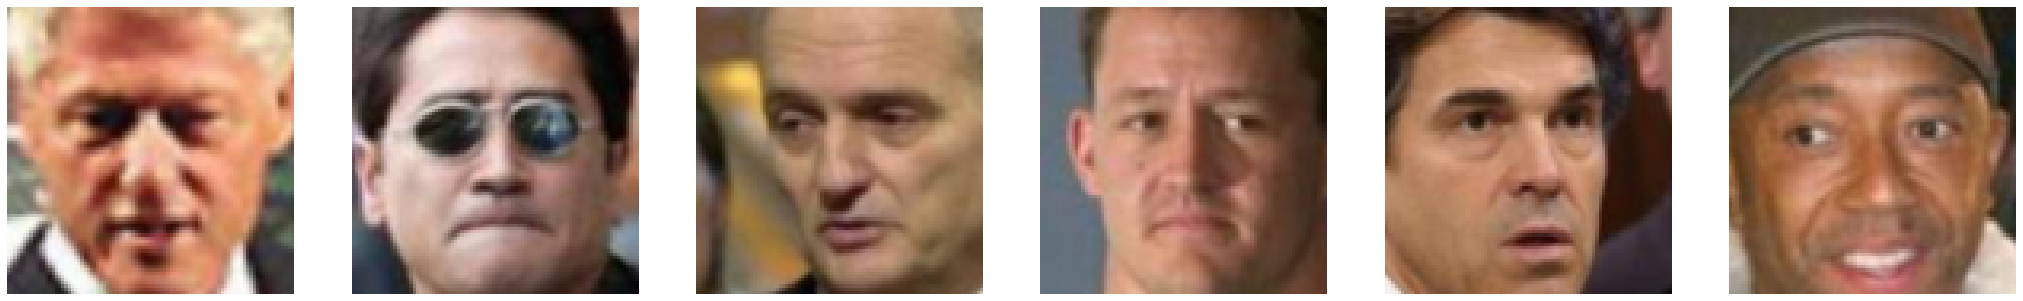

In [ ]:
plt.figure(figsize=(36, 12))
random_image = int(np.random.uniform(0,100))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(test_dataset[random_image+i].numpy().transpose((1, 2, 0)))

In [ ]:
torch.cuda.empty_cache()
# del autoencoder
autoencoder = Autoencoder_v2().to(DEVICE)
summary(autoencoder, (3,90,90))

torch.Size([2, 3, 90, 90])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 90, 90]             896
              ReLU-2           [-1, 32, 90, 90]               0
            Conv2d-3           [-1, 64, 45, 45]          18,496
              ReLU-4           [-1, 64, 45, 45]               0
            Conv2d-5           [-1, 64, 41, 41]          36,928
              ReLU-6           [-1, 64, 41, 41]               0
            Conv2d-7          [-1, 128, 20, 20]         131,200
              ReLU-8          [-1, 128, 20, 20]               0
            Conv2d-9          [-1, 256, 10, 10]         524,544
             ReLU-10          [-1, 256, 10, 10]               0
          Flatten-11                [-1, 25600]               0
           Linear-12                 [-1, 1600]      40,961,600
             ReLU-13                 [-1, 1600]               0
           L

epoch:   3%|▎         | 1/30 [00:55<26:40, 55.19s/it]


Epoch 001 train_loss: 0.0311 val_loss 0.0199


epoch:   7%|▋         | 2/30 [01:50<25:45, 55.18s/it]


Epoch 002 train_loss: 0.0183 val_loss 0.0180


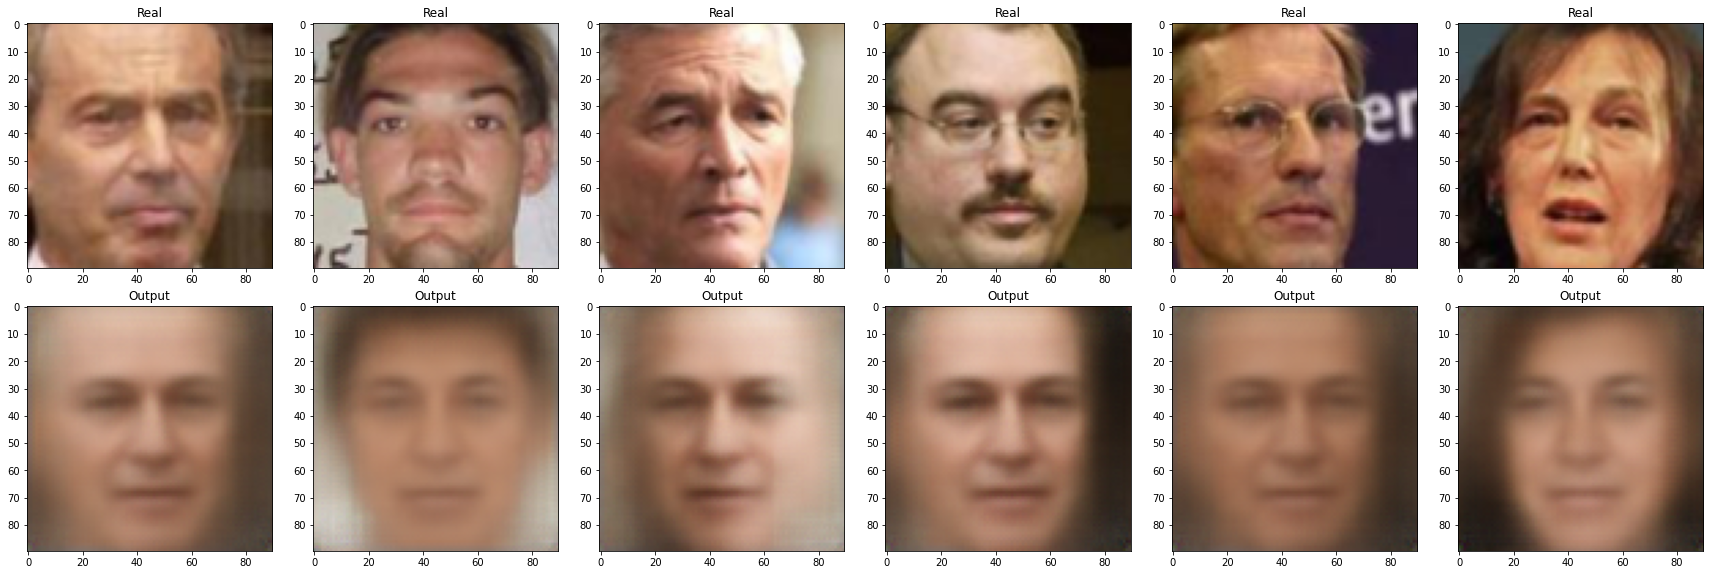

epoch:  10%|█         | 3/30 [02:48<25:11, 55.99s/it]


Epoch 003 train_loss: 0.0159 val_loss 0.0149


epoch:  13%|█▎        | 4/30 [03:43<24:11, 55.82s/it]


Epoch 004 train_loss: 0.0140 val_loss 0.0143


epoch:  17%|█▋        | 5/30 [04:38<23:09, 55.59s/it]


Epoch 005 train_loss: 0.0131 val_loss 0.0129


epoch:  20%|██        | 6/30 [05:33<22:11, 55.49s/it]


Epoch 006 train_loss: 0.0120 val_loss 0.0136


epoch:  23%|██▎       | 7/30 [06:29<21:15, 55.45s/it]


Epoch 007 train_loss: 0.0112 val_loss 0.0115


epoch:  27%|██▋       | 8/30 [07:24<20:18, 55.37s/it]


Epoch 008 train_loss: 0.0103 val_loss 0.0130


epoch:  30%|███       | 9/30 [08:19<19:22, 55.34s/it]


Epoch 009 train_loss: 0.0098 val_loss 0.0105


epoch:  33%|███▎      | 10/30 [09:15<18:27, 55.36s/it]


Epoch 010 train_loss: 0.0091 val_loss 0.0108


epoch:  37%|███▋      | 11/30 [10:10<17:32, 55.39s/it]


Epoch 011 train_loss: 0.0087 val_loss 0.0091


epoch:  40%|████      | 12/30 [11:06<16:38, 55.46s/it]


Epoch 012 train_loss: 0.0082 val_loss 0.0089


epoch:  43%|████▎     | 13/30 [12:01<15:42, 55.45s/it]


Epoch 013 train_loss: 0.0079 val_loss 0.0089


epoch:  47%|████▋     | 14/30 [12:57<14:47, 55.44s/it]


Epoch 014 train_loss: 0.0076 val_loss 0.0085


epoch:  50%|█████     | 15/30 [13:52<13:52, 55.48s/it]


Epoch 015 train_loss: 0.0073 val_loss 0.0085


epoch:  53%|█████▎    | 16/30 [14:48<12:57, 55.51s/it]


Epoch 016 train_loss: 0.0071 val_loss 0.0088


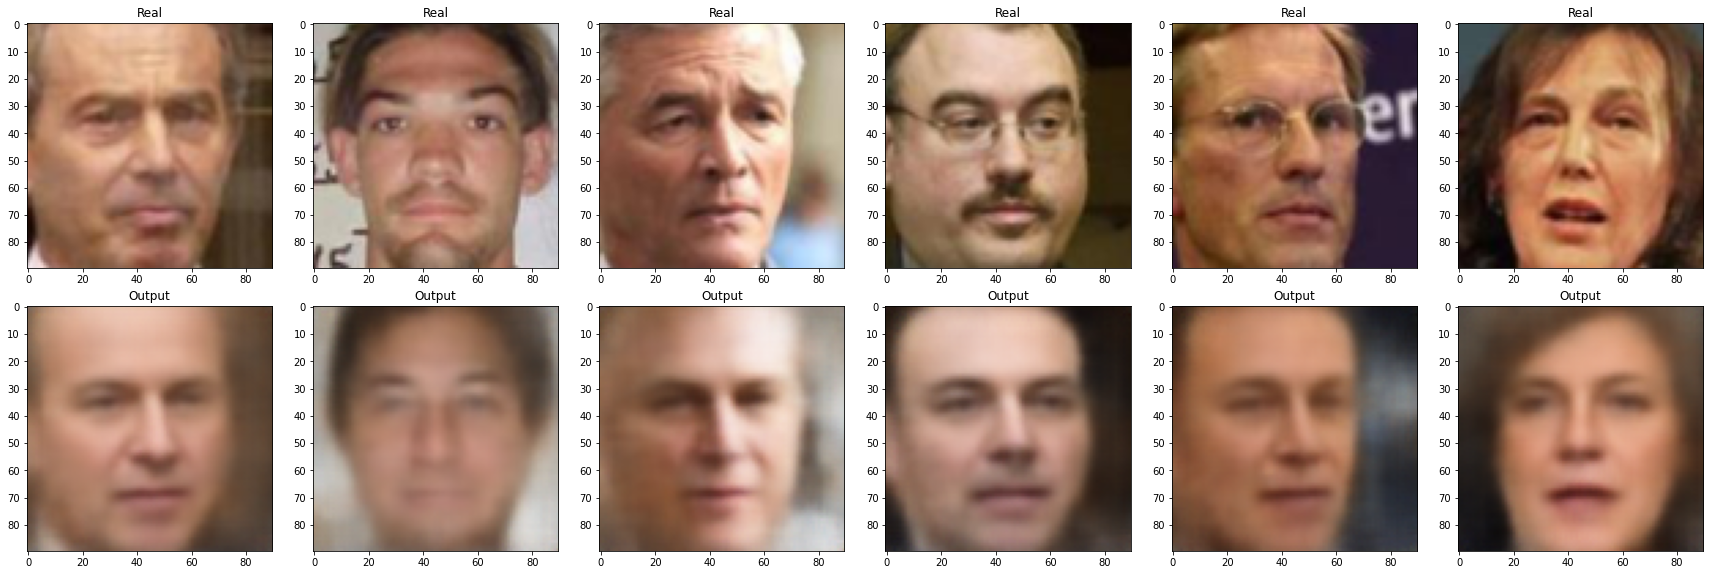

epoch:  57%|█████▋    | 17/30 [15:46<12:11, 56.31s/it]


Epoch 017 train_loss: 0.0068 val_loss 0.0083


epoch:  60%|██████    | 18/30 [16:41<11:11, 55.98s/it]


Epoch 018 train_loss: 0.0065 val_loss 0.0085


epoch:  63%|██████▎   | 19/30 [17:36<10:12, 55.68s/it]


Epoch 019 train_loss: 0.0062 val_loss 0.0085


epoch:  67%|██████▋   | 20/30 [18:31<09:15, 55.57s/it]


Epoch 020 train_loss: 0.0060 val_loss 0.0083


epoch:  70%|███████   | 21/30 [19:27<08:19, 55.49s/it]


Epoch 021 train_loss: 0.0053 val_loss 0.0081


epoch:  73%|███████▎  | 22/30 [20:22<07:22, 55.34s/it]


Epoch 022 train_loss: 0.0050 val_loss 0.0082


epoch:  77%|███████▋  | 23/30 [21:17<06:27, 55.32s/it]


Epoch 023 train_loss: 0.0048 val_loss 0.0085


epoch:  80%|████████  | 24/30 [22:12<05:32, 55.34s/it]


Epoch 024 train_loss: 0.0046 val_loss 0.0085


epoch:  83%|████████▎ | 25/30 [23:08<04:36, 55.34s/it]


Epoch 025 train_loss: 0.0045 val_loss 0.0085


epoch:  87%|████████▋ | 26/30 [24:03<03:41, 55.34s/it]


Epoch 026 train_loss: 0.0043 val_loss 0.0086


epoch:  90%|█████████ | 27/30 [24:58<02:45, 55.23s/it]


Epoch 027 train_loss: 0.0042 val_loss 0.0086


epoch:  93%|█████████▎| 28/30 [25:53<01:50, 55.27s/it]


Epoch 028 train_loss: 0.0041 val_loss 0.0088


epoch:  97%|█████████▋| 29/30 [26:49<00:55, 55.28s/it]


Epoch 029 train_loss: 0.0039 val_loss 0.0088


epoch: 100%|██████████| 30/30 [27:44<00:00, 55.16s/it]


Epoch 030 train_loss: 0.0038 val_loss 0.0088


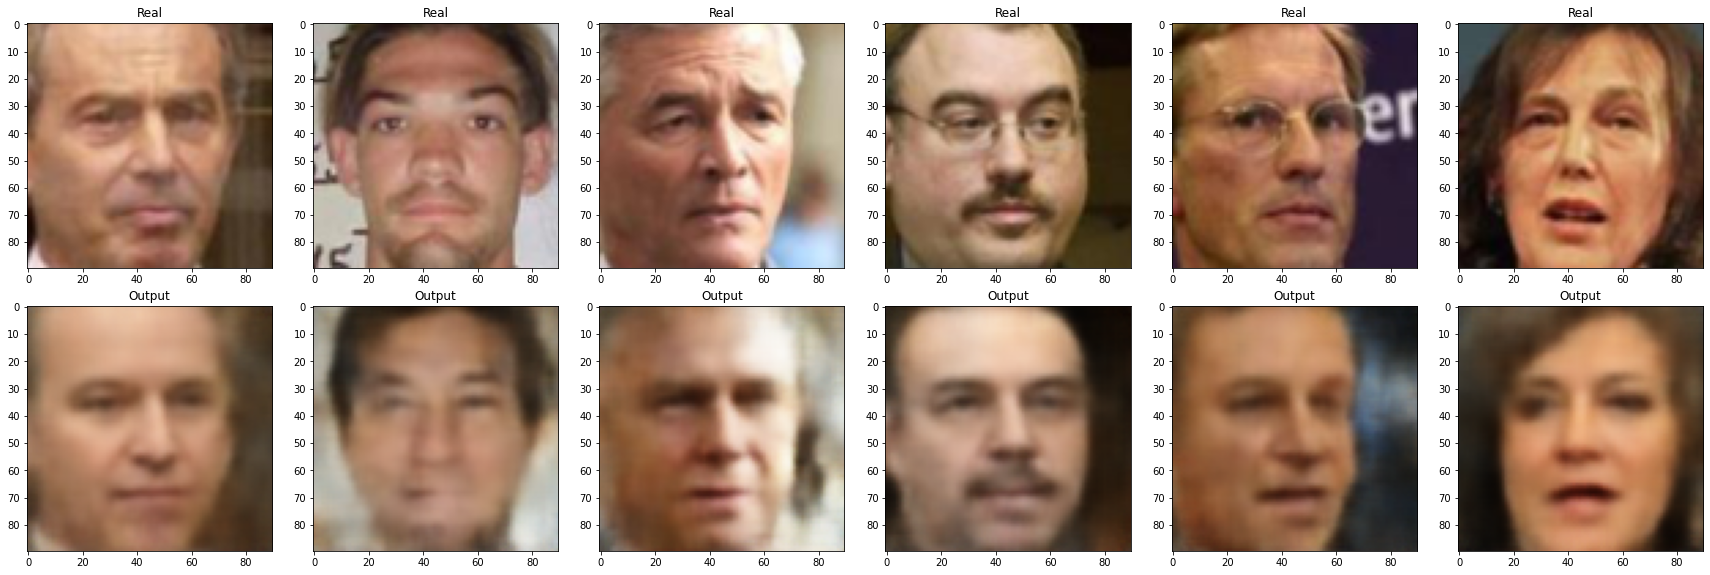

epoch: 100%|██████████| 30/30 [27:46<00:00, 55.56s/it]


In [ ]:
torch.cuda.empty_cache()
del autoencoder
autoencoder = Autoencoder_v2().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters())

history = train(train_dataloader, test_dataloader, model=autoencoder, epochs=30, opt=optimizer, criterion=criterion)

In [ ]:
# Монитруем диск 
drive.mount('/content/gdrive/', force_remount=True)
model_name = "AE"
PATH = "gdrive/My Drive/nn/" + model_name + "/model_weights_v2.pth"
torch.save(autoencoder.state_dict(), PATH)

Mounted at /content/gdrive/


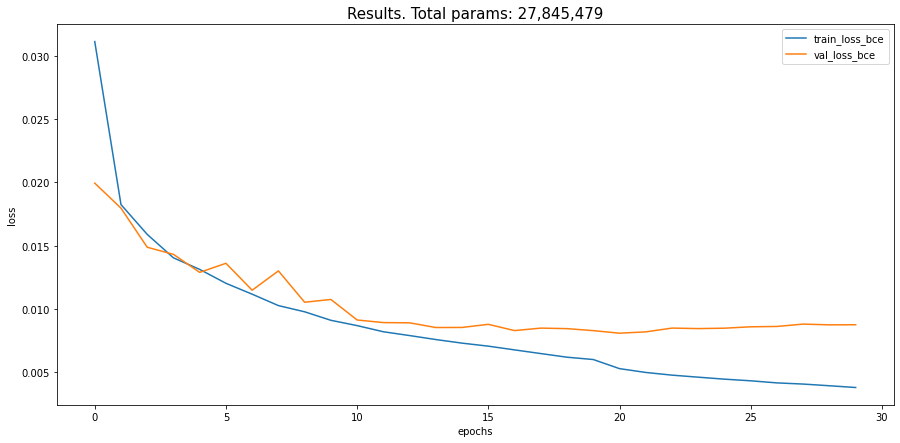

In [ ]:
# Переобучились 
train_loss_bce, val_loss_bce = zip(*history)
fig = plt.figure(figsize=(15, 7))
plt.title("Results. Total params: 27,845,479", fontsize=15)
plt.plot(train_loss_bce, label="train_loss_bce")
plt.plot(val_loss_bce, label="val_loss_bce")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Sampling

In [ ]:
drive.mount('/content/gdrive/', force_remount=True)
model_name = "AE"
PATH = "gdrive/My Drive/nn/" + model_name + "/model_weights_v2.pth"
autoencoder = Autoencoder_v2().to(DEVICE)
autoencoder.load_state_dict(torch.load(PATH))

Mounted at /content/gdrive/


<All keys matched successfully>

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(20, 512)
z = torch.tensor(z).float().to(DEVICE)

In [ ]:
output = autoencoder.decoder(z)
output = output.detach().cpu()

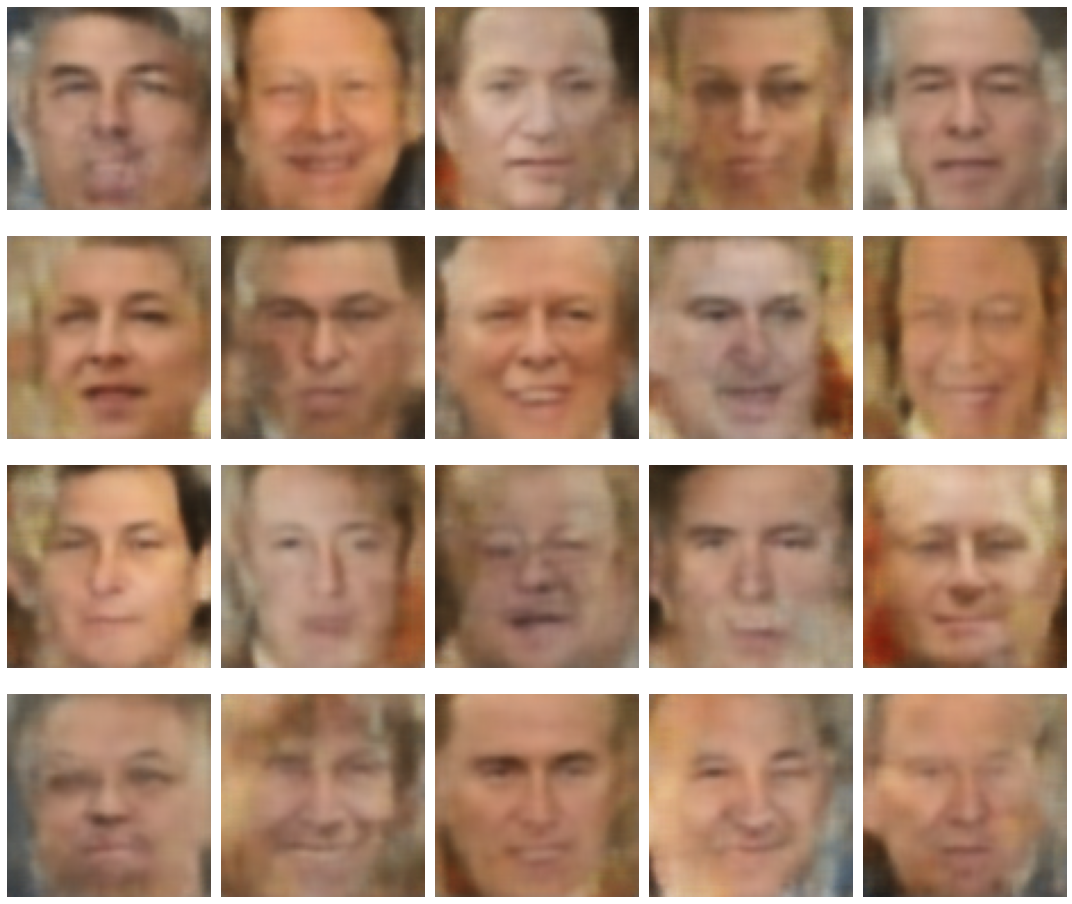

In [ ]:
number = 0
fig, axes = plt.subplots(4, 5, figsize=(15, 13))
for i in range(0,4):
    for j in range(0,5):
        axes[i][j].imshow(output[number].numpy().transpose((1, 2, 0)))
        number += 1
        axes[i][j].axis("off")
plt.tight_layout()

plt.show()

## Time to make fun!

In [ ]:
male_smiles = attrs.loc[attrs["Male"] > 1.5].sort_values(["Smiling"], ascending=False).index[:10].values
female_smiles = attrs.loc[attrs["Male"] < -1.5].sort_values(["Smiling"], ascending=False).index[:10].values
indexes_smiles = np.concatenate((male_smiles, female_smiles))

male_sadness= attrs.loc[attrs["Male"] > 1.5].sort_values(["Smiling"], ascending=False).index[-10:].values
female_sadness = attrs.loc[attrs["Male"] < -1.5].sort_values(["Smiling"], ascending=False).index[-10:].values
indexes_sadness = np.concatenate((male_sadness, female_sadness))

In [ ]:
dataset_smile = autoencoder_dataset(photo_paths[indexes_smiles])
dataloader_smile = DataLoader(dataset_smile, shuffle=False, batch_size=20)
X_smile = next(iter(dataloader_smile))

dataset_sadness = autoencoder_dataset(photo_paths[indexes_sadness])
dataloader_sadness = DataLoader(dataset_sadness, shuffle=False, batch_size=20)
X_sadness = next(iter(dataloader_sadness))

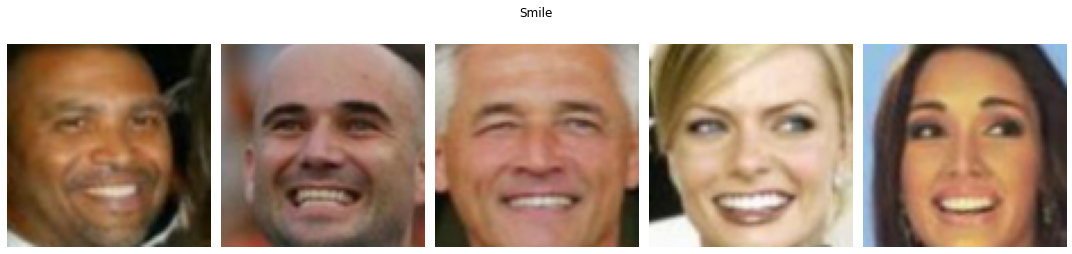

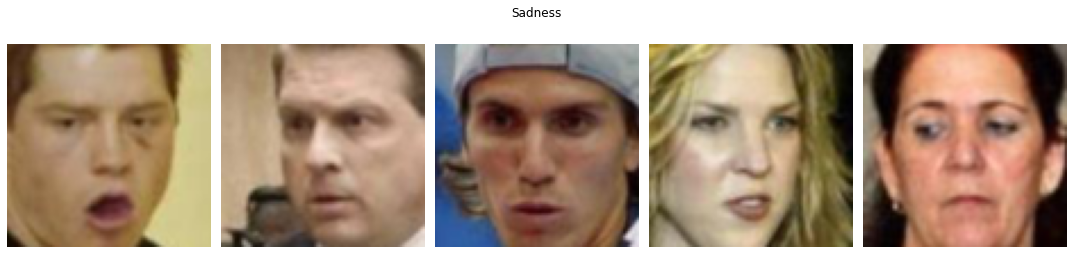

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
fig.suptitle('Smile')
for i in range(0,5):
    axes[i].imshow(X_smile[i*4].cpu().numpy().transpose((1, 2, 0)))
    axes[i].axis("off")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(15, 4))
fig.suptitle('Sadness')
for i in range(0,5):
    axes[i].imshow(X_sadness[i*4].cpu().numpy().transpose((1, 2, 0)))
    axes[i].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
autoencoder.eval()
X_smile = X_smile.to(DEVICE)
X_sadness = X_sadness.to(DEVICE)

with torch.set_grad_enabled(False):
    reconstruction_smile, latent_smile = autoencoder(X_smile)
    reconstruction_sad, latent_sadness = autoencoder(X_sadness)

In [ ]:
latent_smile_mean = latent_smile.mean(dim=0)
latent_sadness_mean = latent_sadness.mean(dim=0)

diff = latent_smile_mean - latent_sadness_mean
latent_reluctant_smile = latent_sadness + diff

reconstruction_reluctant_smile = autoencoder.decoder(latent_reluctant_smile)
reconstruction_reluctant_smile = reconstruction_reluctant_smile.detach().cpu()

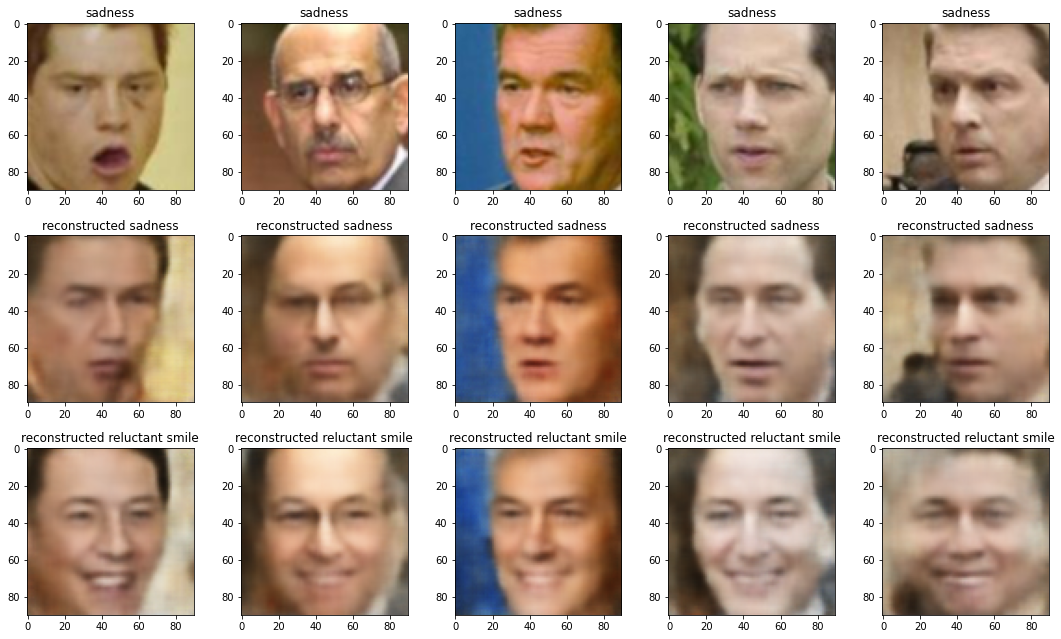

In [ ]:
number = 0
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for j in range(0,5):
    axes[0][j].imshow(X_sadness[j].cpu().numpy().transpose((1, 2, 0)))
    axes[0][j].set_title("sadness")
    axes[1][j].imshow(reconstruction_sad.cpu()[j].numpy().transpose((1, 2, 0)))
    axes[1][j].set_title("reconstructed sadness")
    axes[2][j].imshow(reconstruction_reluctant_smile.cpu()[j].numpy().transpose((1, 2, 0)))
    axes[2][j].set_title("reconstructed reluctant smile")
plt.tight_layout()
plt.show()

# Variational Autoencoder

In [4]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Архитектура модели и обучение

In [7]:
class VAE_v1(nn.Module):
    def __init__(self, out_dim=28**2, latent_dim = 20):
        super().__init__()
        self.fc_e = nn.Sequential(
            nn.Flatten(),
            nn.Linear(out_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        self.fc_latent_mean = nn.Linear(256, latent_dim)
        self.fc_latent_std = nn.Linear(256, latent_dim)

        self.fc_d = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim),
            nn.Unflatten(1, (28, 28)),
            nn.Sigmoid()
        )

    def encoder(self, x):
        # encoder
        x = self.fc_e(x)
        mu = self.fc_latent_mean(x)
        log_var = self.fc_latent_std(x)
        return mu, log_var
    
    def gaussian_sampler(self, mu, log_var):

        if self.training:
            std = torch.exp(0.5 * log_var) # standard deviation
            eps = torch.randn_like(std).to(DEVICE) # `randn_like` as we need the same size to(DEVICE)
            sample = eps.mul(std).add_(mu) # sampling as if coming from the input space
            return sample
        else:
            return mu
    
    def decoder(self, z):
        # decoder
        reconstruction = self.fc_d(z)
        return reconstruction

    def forward(self, x):
        
        mu, log_var = self.encoder(x)
        z = self.gaussian_sampler(mu, log_var)
        reconstruction = self.decoder(z)

        return mu, log_var, reconstruction

In [8]:
torch.cuda.empty_cache()
# del autoencoder
VAE = VAE_v1().to(DEVICE)
summary(VAE, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 20]           5,140
            Linear-7                   [-1, 20]           5,140
            Linear-8                  [-1, 256]           5,376
              ReLU-9                  [-1, 256]               0
           Linear-10                  [-1, 512]         131,584
             ReLU-11                  [-1, 512]               0
           Linear-12                  [-1, 784]         402,192
        Unflatten-13               [-1, 28, 28]               0
          Sigmoid-14               [-1,

In [11]:
def loss_vae(reconstruction, x, mu, log_var):
    # часть функции потерь, которая отвечает за качество реконструкции
    BCE_loss = nn.BCELoss(reduction="sum")

    log_likelihood = BCE_loss(reconstruction, x)
    # часть функции потерь, которая отвечает за "близость" латентных представлений разных лейблов
    KL_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return log_likelihood +  KL_divergence
    
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    loss_avg = 0
  
    for inputs, label in train_loader:
        inputs = inputs.to(DEVICE)

        mu, log_var, reconstruction = model(inputs)
        loss = criterion(reconstruction, inputs.squeeze(), mu, log_var) # 
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_avg += loss.item()

    train_loss = loss_avg / len(train_loader)
    return train_loss

def eval_epoch(model, val_loader, criterion):
    model.eval()
    loss_avg = 0

    for inputs, label in val_loader:
        inputs = inputs.to(DEVICE)

        with torch.set_grad_enabled(False):
            mu, log_var, reconstruction = model(inputs)
            loss = criterion(reconstruction, inputs.squeeze(), mu, log_var) # 

        loss_avg += loss.item()

    val_loss = loss_avg / len(val_loader)
    return val_loss

def train(train_loader, val_loader, model, epochs, opt, criterion):

    X_val, label = next(iter(val_loader))

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        # exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=15, gamma=0.1)

        for epoch in range(epochs):
            train_loss = fit_epoch(model, train_loader, criterion, opt)
            
            val_loss = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, val_loss))
            
            # exp_lr_scheduler.step()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss))

            if epoch in [1, epochs//2 ,epochs-1]:
                visualisation(X_val, model)
            
    return history

def visualisation(X_val, model):

    model.eval()
    inputs = X_val.to(DEVICE)
    mu, log_var, reconstruction = model(inputs)
    reconstruction = reconstruction.detach().cpu()
    inputs = inputs.cpu()

    # Visualize tools
    f, axes = plt.subplots(2,6,figsize=(24,8))

    for k in range(6):
        axes[0][k].imshow(inputs[k+1].numpy().squeeze())
        axes[0][k].set_title('Real')
        # plt.axis('off')

        axes[1][k].imshow(reconstruction[k+1].numpy().squeeze())
        axes[1][k].set_title('Output')
    plt.tight_layout()
    plt.show()

epoch:   5%|▌         | 1/20 [00:10<03:10, 10.04s/it]


Epoch 001 train_loss: 4603.8869 val_loss 3664.4653


epoch:  10%|█         | 2/20 [00:20<03:00, 10.01s/it]


Epoch 002 train_loss: 3710.4316 val_loss 3427.0635


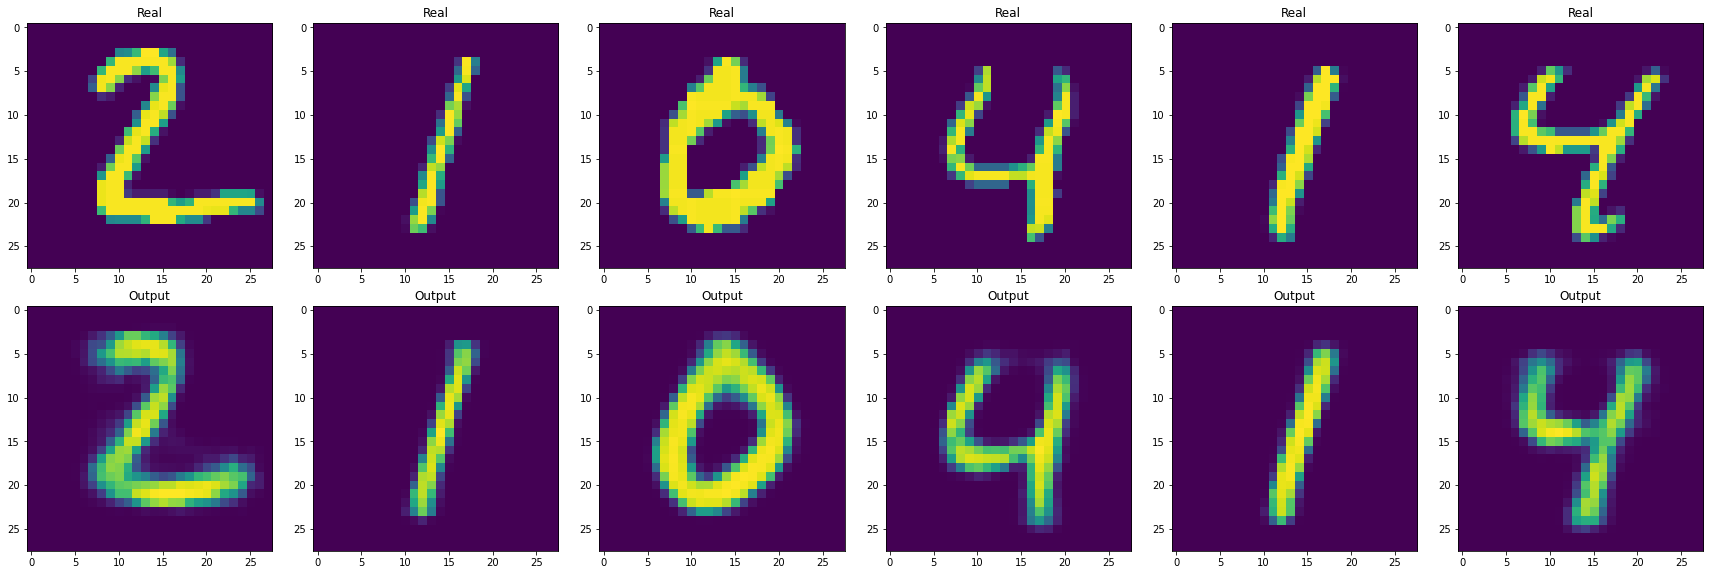

epoch:  15%|█▌        | 3/20 [00:31<02:59, 10.54s/it]


Epoch 003 train_loss: 3566.6921 val_loss 3372.0962


epoch:  20%|██        | 4/20 [00:41<02:46, 10.38s/it]


Epoch 004 train_loss: 3493.2658 val_loss 3294.2043


epoch:  25%|██▌       | 5/20 [00:51<02:34, 10.29s/it]


Epoch 005 train_loss: 3436.1145 val_loss 3241.6198


epoch:  30%|███       | 6/20 [01:01<02:23, 10.22s/it]


Epoch 006 train_loss: 3392.0805 val_loss 3225.8530


epoch:  35%|███▌      | 7/20 [01:11<02:11, 10.14s/it]


Epoch 007 train_loss: 3359.4590 val_loss 3207.9727


epoch:  40%|████      | 8/20 [01:21<02:01, 10.11s/it]


Epoch 008 train_loss: 3337.4116 val_loss 3194.4308


epoch:  45%|████▌     | 9/20 [01:31<01:51, 10.10s/it]


Epoch 009 train_loss: 3316.7517 val_loss 3157.0638


epoch:  50%|█████     | 10/20 [01:41<01:40, 10.07s/it]


Epoch 010 train_loss: 3302.5728 val_loss 3163.3511


epoch:  55%|█████▌    | 11/20 [01:52<01:30, 10.07s/it]


Epoch 011 train_loss: 3288.6201 val_loss 3138.4340


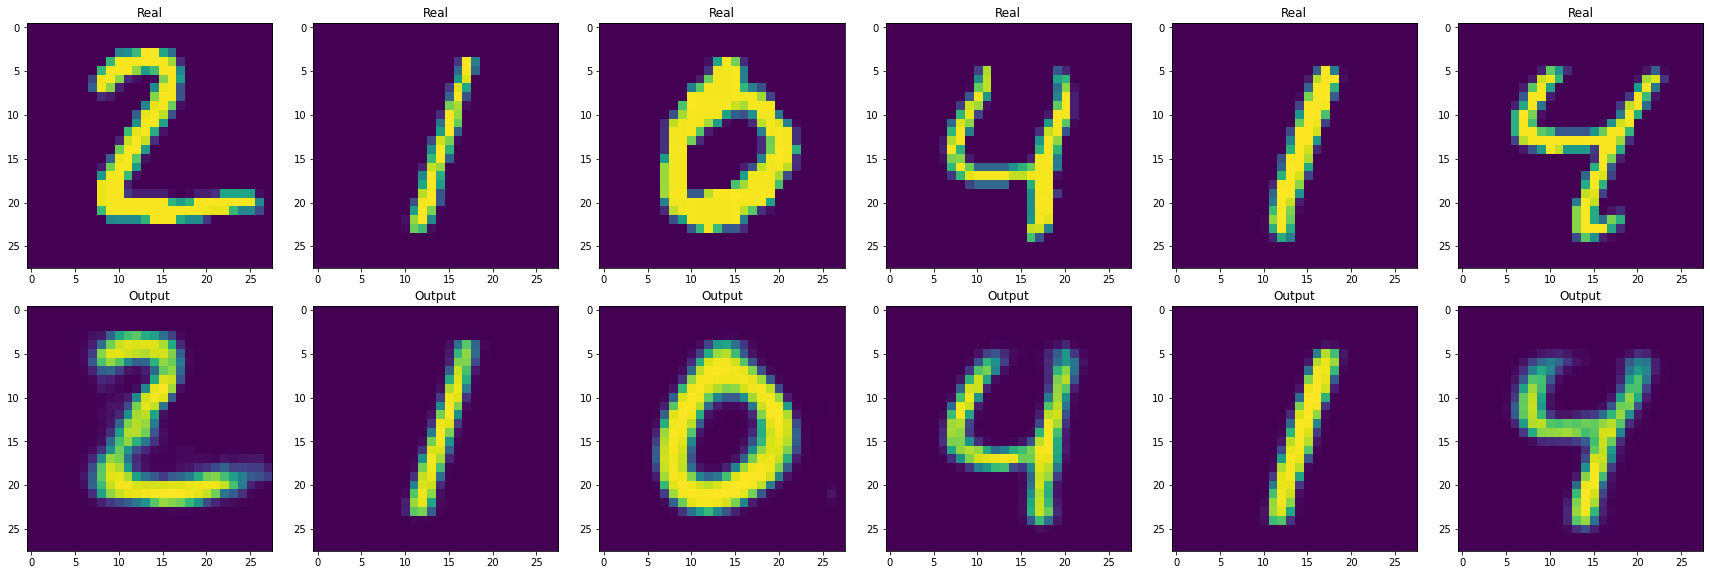

epoch:  60%|██████    | 12/20 [02:03<01:24, 10.58s/it]


Epoch 012 train_loss: 3277.3590 val_loss 3145.8853


epoch:  65%|██████▌   | 13/20 [02:13<01:13, 10.45s/it]


Epoch 013 train_loss: 3269.4451 val_loss 3136.2530


epoch:  70%|███████   | 14/20 [02:24<01:02, 10.36s/it]


Epoch 014 train_loss: 3259.9096 val_loss 3147.8923


epoch:  75%|███████▌  | 15/20 [02:34<00:51, 10.25s/it]


Epoch 015 train_loss: 3253.1654 val_loss 3129.8302


epoch:  80%|████████  | 16/20 [02:44<00:41, 10.25s/it]


Epoch 016 train_loss: 3245.1231 val_loss 3112.6008


epoch:  85%|████████▌ | 17/20 [02:54<00:30, 10.20s/it]


Epoch 017 train_loss: 3237.1427 val_loss 3111.7247


epoch:  90%|█████████ | 18/20 [03:04<00:20, 10.16s/it]


Epoch 018 train_loss: 3233.1699 val_loss 3114.8594


epoch:  95%|█████████▌| 19/20 [03:14<00:10, 10.15s/it]


Epoch 019 train_loss: 3227.2461 val_loss 3106.9558


epoch: 100%|██████████| 20/20 [03:24<00:00, 10.17s/it]


Epoch 020 train_loss: 3222.4383 val_loss 3123.6288


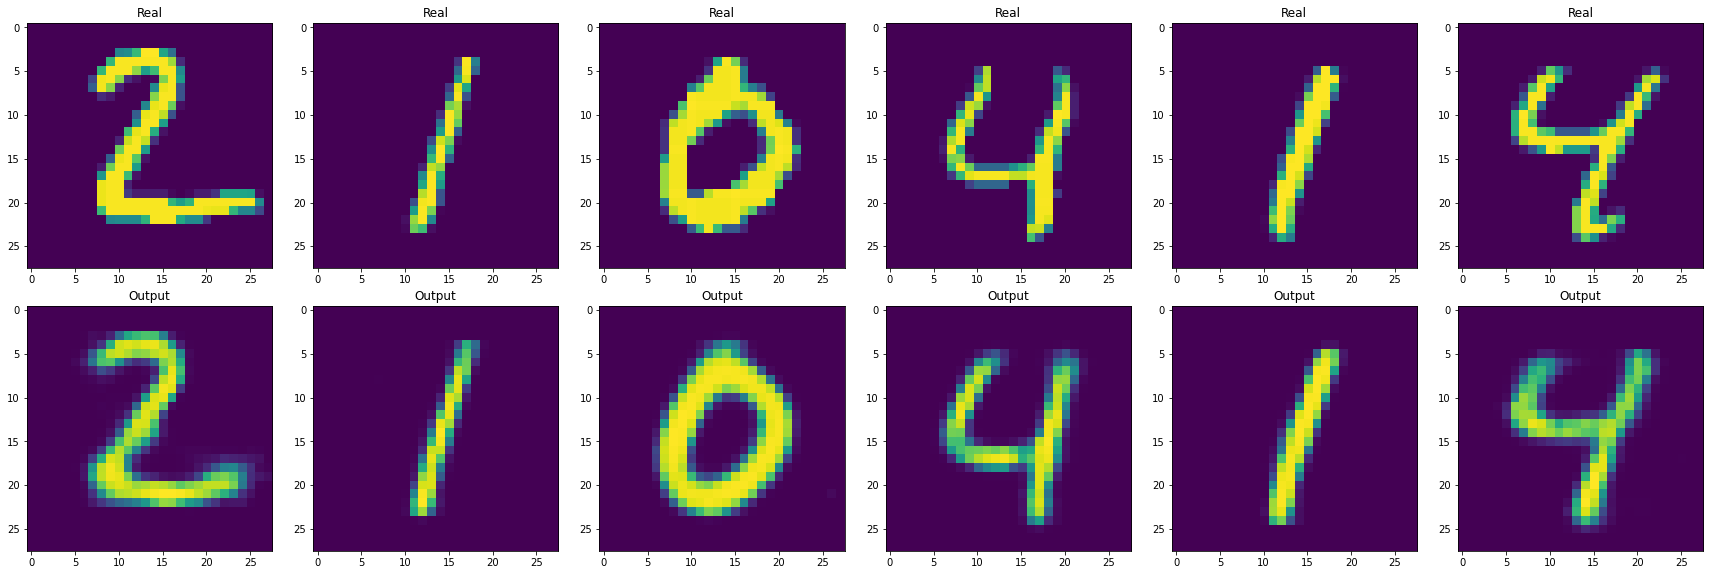

epoch: 100%|██████████| 20/20 [03:26<00:00, 10.33s/it]


In [12]:
torch.cuda.empty_cache()
VAE = VAE_v1().to(DEVICE)
criterion = loss_vae
optimizer = torch.optim.Adam(VAE.parameters())

history = train(train_loader, test_loader, model=VAE, epochs=20, opt=optimizer, criterion=criterion)

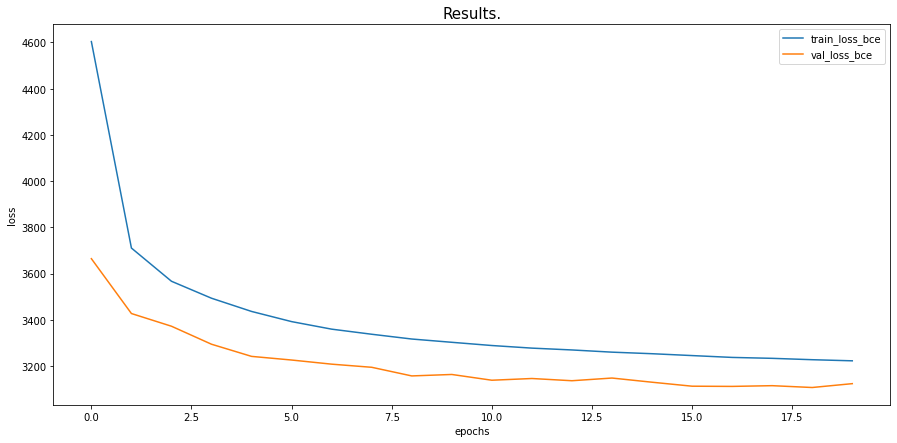

In [13]:
train_loss_bce, val_loss_bce = zip(*history)
fig = plt.figure(figsize=(15, 7))
plt.title("Results.", fontsize=15)
plt.plot(train_loss_bce, label="train_loss_bce")
plt.plot(val_loss_bce, label="val_loss_bce")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [15]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 20) for i in range(32)])
VAE.eval()
output = VAE.decoder(torch.tensor(z).float().to(DEVICE))
output = output.detach().cpu().numpy()

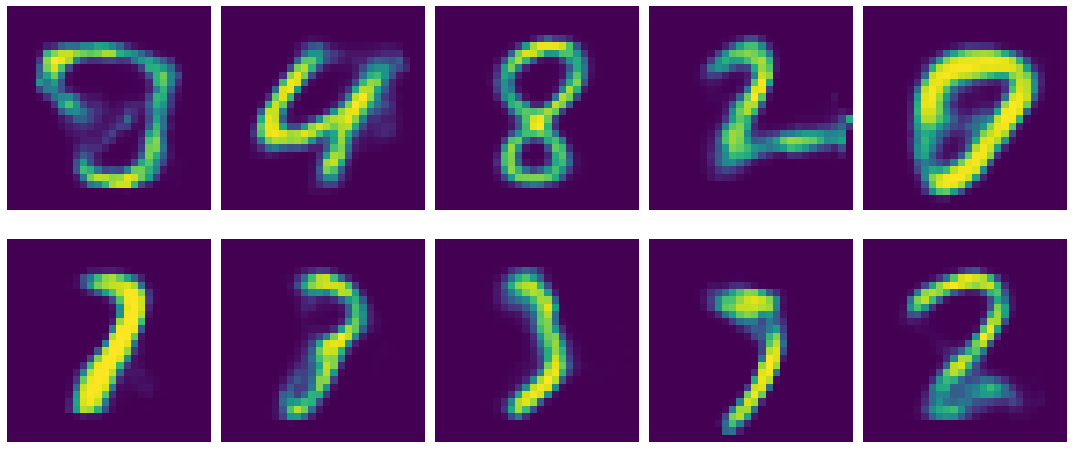

In [16]:
number = 0
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
for i in range(0,2):
    for j in range(0,5):
        axes[i][j].imshow(output[number])
        number += 1
        axes[i][j].axis("off")
plt.tight_layout()

plt.show()

## Latent Representation

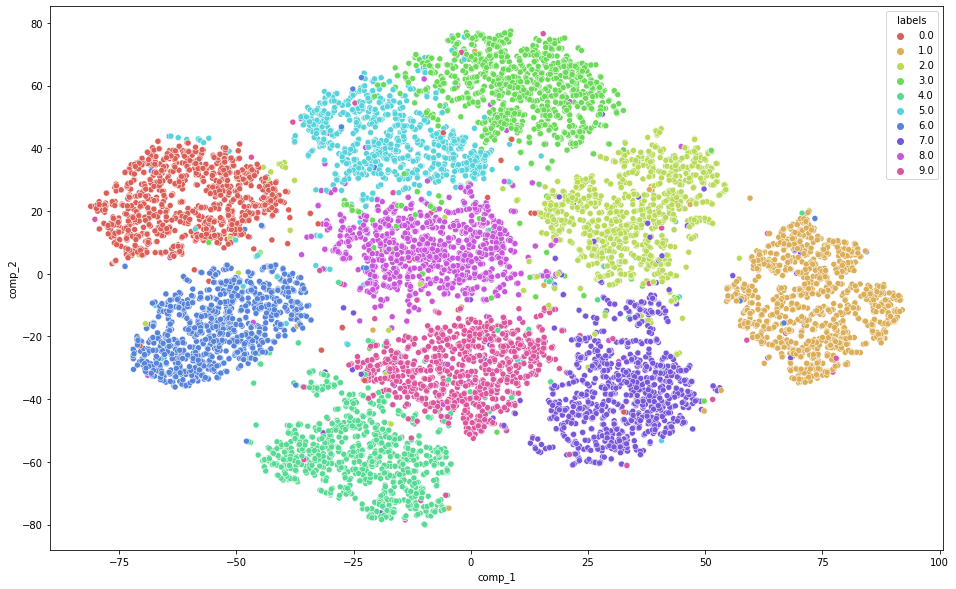

In [17]:
# Визуально разделимые кластеры
mu_concat = np.ones(shape=(0,20))
labels_list = np.array([])
for input, labels in test_loader:
    labels_list = np.append(labels_list, labels)
    input = input.to(DEVICE)
    VAE.eval()
    with torch.no_grad():
        mu, _ = VAE.encoder(input)
        mu_concat = np.concatenate([mu_concat, mu.cpu().numpy()])


X_embedded = TSNE(n_components=2).fit_transform(mu_concat)
X_embedded = np.hstack([X_embedded,labels_list.reshape(-1,1)])
df = pd.DataFrame(data=X_embedded, columns=["comp_1", "comp_2", "labels"])


plt.figure(figsize=(16,10))
sns.scatterplot(
    x="comp_1", y="comp_2",
    hue="labels",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full"
)
plt.show()

# Conditional Variational Autoencoder


In [18]:
class CVAE_v1(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        self.lb = LabelBinarizer()

        self.fc_e = nn.Sequential(
            nn.Linear(794, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        self.fc_latent_mean = nn.Linear(256, latent_dim)
        self.fc_latent_std = nn.Linear(256, latent_dim)

        self.fc_d = nn.Sequential(
            nn.Linear(latent_dim+10, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 794),
            nn.Sigmoid()
        )

    def to_categrical(self, y: torch.FloatTensor):
        y_n = y.cpu().numpy()
        self.lb.fit(list(range(0,10)))
        y_one_hot = self.lb.transform(y_n)
        floatTensor = torch.FloatTensor(y_one_hot).to(DEVICE)
        return floatTensor

    def encode(self, x, class_num):
        class_num_c = self.to_categrical(class_num)
        con = torch.cat((x, class_num_c), 1)

        h1 = self.fc_e(con)
        mu = self.fc_latent_mean(h1)
        log_var = self.fc_latent_std(h1)
        return mu, log_var # , class_num_c # class_num
    
    def gaussian_sampler(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5*log_var)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z, class_num):
        class_num_c = self.to_categrical(class_num)
        cat = torch.cat((z, class_num_c), 1)

        reconstruction = self.fc_d(cat)
        return reconstruction

    def forward(self, x, y):
        mu, log_var = self.encode(x.view(-1, 784), y)
        z = self.gaussian_sampler(mu, log_var)
        reconstruction = self.decode(z, y)
        return reconstruction, mu, log_var

In [19]:
def loss_vae(reconstruction, x, mu, log_var):
    # часть функции потерь, которая отвечает за качество реконструкции
    BCE_loss = nn.BCELoss(reduction="sum")
    log_likelihood = BCE_loss(reconstruction, x)

    # часть функции потерь, которая отвечает за "близость" латентных представлений разных лейблов
    KL_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return log_likelihood +  KL_divergence
    
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    loss_avg = 0
  
    for inputs, label in train_loader:
        inputs = inputs.to(DEVICE)
        label = label.to(DEVICE)

        reconstruction, mu, log_var = model(inputs, label)

        flat_data = inputs.view(-1, inputs.shape[2]*inputs.shape[3])
        y_condition = model.to_categrical(label)
        con = torch.cat((flat_data, y_condition), 1)

        loss = criterion(reconstruction, con, mu, log_var) # 
        loss.backward()
        optimizer.step()

        loss_avg += loss.item()
        optimizer.zero_grad()

    train_loss = loss_avg / len(train_loader)
    return train_loss

def eval_epoch(model, val_loader, criterion):
    model.eval()
    loss_avg = 0

    for inputs, label in val_loader:
        inputs = inputs.to(DEVICE)
        label = label.to(DEVICE)

        with torch.set_grad_enabled(False):
            reconstruction, mu, log_var = model(inputs, label)

            flat_data = inputs.view(-1, inputs.shape[2]*inputs.shape[3])
            y_condition = model.to_categrical(label)
            con = torch.cat((flat_data, y_condition), 1)

            loss = criterion(reconstruction, con, mu, log_var) # 

        loss_avg += loss.item()

    val_loss = loss_avg / len(val_loader)
    return val_loss

def train(train_loader, val_loader, model, epochs, opt, criterion):

    X_val, label = next(iter(val_loader))

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=15, gamma=0.1)

        for epoch in range(epochs):
            train_loss = fit_epoch(model, train_loader, criterion, opt)
            
            val_loss = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, val_loss))
            
            exp_lr_scheduler.step()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss))

            if epoch in [1, epochs//2 ,epochs-1]:
                visualisation(X_val, label, model)
            
    return history

def visualisation(X_val, label, model):

    model.eval()
    inputs = X_val.to(DEVICE)
    label = label.to(DEVICE)
    reconstruction, mu, log_var = model(inputs, label)
    reconstruction = reconstruction.detach().cpu()

    reconstruction = reconstruction[:, 0:reconstruction.shape[1]-10]
    print(reconstruction.shape)
    reconstruction = reconstruction.view(32, 1, 28,28)

    inputs = inputs.cpu()

    # Visualize tools
    f, axes = plt.subplots(2,6,figsize=(24,8))

    for k in range(6):
        axes[0][k].imshow(inputs[k+1].numpy().squeeze())
        axes[0][k].set_title('Real')
        # plt.axis('off')

        axes[1][k].imshow(reconstruction[k+1].numpy().squeeze())
        axes[1][k].set_title('Output')
    plt.tight_layout()
    plt.show()

In [ ]:
torch.cuda.empty_cache()
# del autoencoder
CVAE = CVAE_v1().to(DEVICE)
summary(CVAE, (1,28,28))

epoch:   5%|▌         | 1/20 [00:13<04:25, 13.99s/it]


Epoch 001 train_loss: 4425.3565 val_loss 3527.1561


epoch:  10%|█         | 2/20 [00:27<04:10, 13.92s/it]


Epoch 002 train_loss: 3578.9942 val_loss 3298.2538
torch.Size([32, 784])


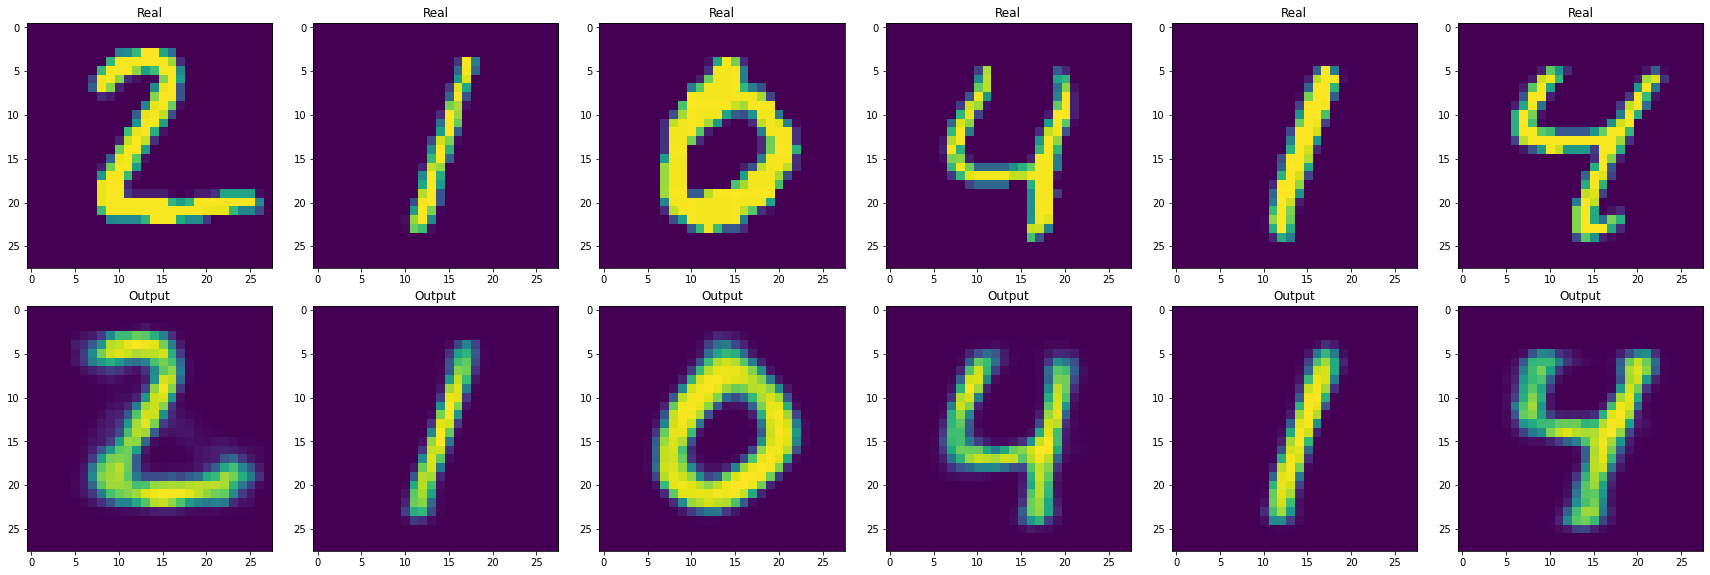

epoch:  15%|█▌        | 3/20 [00:43<04:05, 14.46s/it]


Epoch 003 train_loss: 3420.9463 val_loss 3227.7436


epoch:  20%|██        | 4/20 [00:57<03:48, 14.30s/it]


Epoch 004 train_loss: 3341.2422 val_loss 3147.6082


epoch:  25%|██▌       | 5/20 [01:11<03:32, 14.17s/it]


Epoch 005 train_loss: 3290.5043 val_loss 3133.5085


epoch:  30%|███       | 6/20 [01:25<03:17, 14.10s/it]


Epoch 006 train_loss: 3253.6330 val_loss 3126.0744


epoch:  35%|███▌      | 7/20 [01:39<03:02, 14.04s/it]


Epoch 007 train_loss: 3224.8291 val_loss 3072.4008


epoch:  40%|████      | 8/20 [01:52<02:47, 13.99s/it]


Epoch 008 train_loss: 3202.2776 val_loss 3060.9291


epoch:  45%|████▌     | 9/20 [02:06<02:33, 13.99s/it]


Epoch 009 train_loss: 3183.8666 val_loss 3072.2159


epoch:  50%|█████     | 10/20 [02:20<02:19, 13.94s/it]


Epoch 010 train_loss: 3168.0096 val_loss 3046.8287


epoch:  55%|█████▌    | 11/20 [02:34<02:05, 13.96s/it]


Epoch 011 train_loss: 3153.6611 val_loss 3026.7067
torch.Size([32, 784])


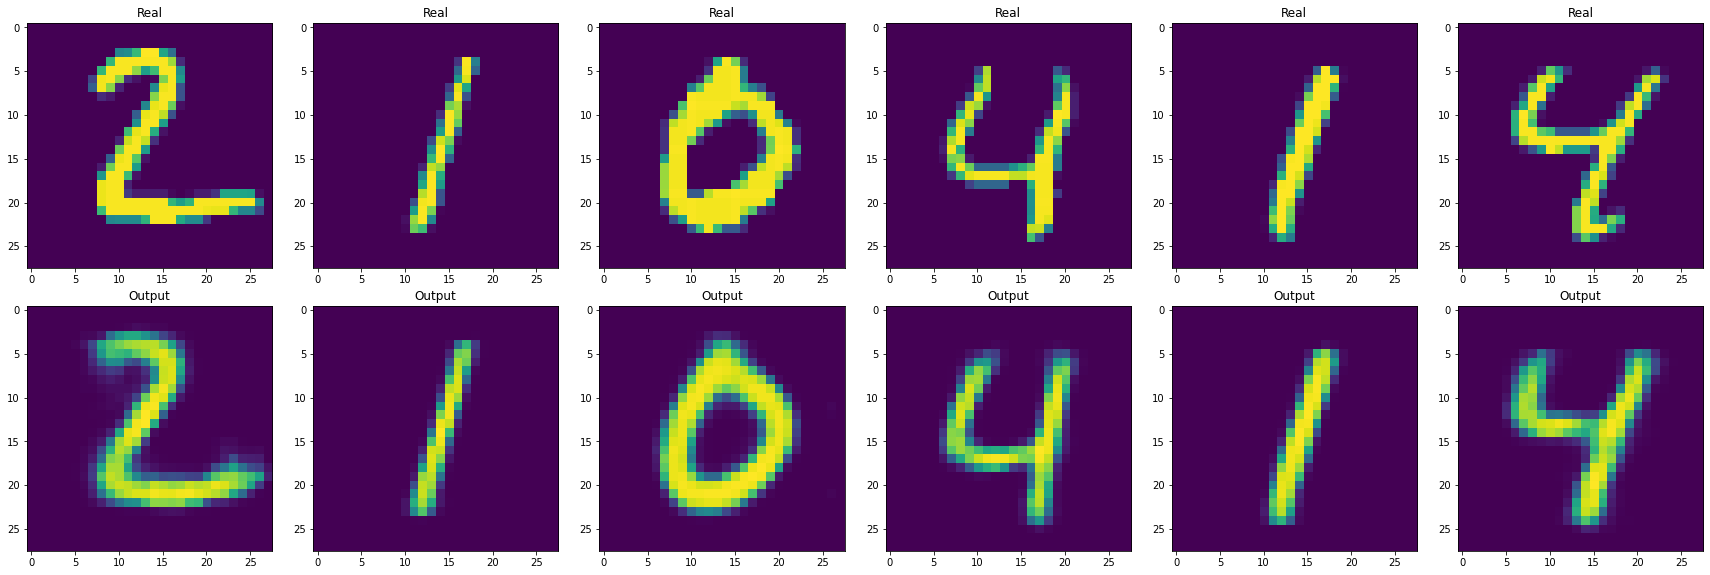

epoch:  60%|██████    | 12/20 [02:50<01:55, 14.48s/it]


Epoch 012 train_loss: 3142.7532 val_loss 3036.1159


epoch:  65%|██████▌   | 13/20 [03:04<01:40, 14.39s/it]


Epoch 013 train_loss: 3133.6339 val_loss 3026.3084


epoch:  70%|███████   | 14/20 [03:19<01:26, 14.39s/it]


Epoch 014 train_loss: 3125.1228 val_loss 3010.2749


epoch:  75%|███████▌  | 15/20 [03:33<01:12, 14.43s/it]


Epoch 015 train_loss: 3117.7458 val_loss 3008.4584


epoch:  80%|████████  | 16/20 [03:48<00:57, 14.46s/it]


Epoch 016 train_loss: 3016.0754 val_loss 2922.8956


epoch:  85%|████████▌ | 17/20 [04:02<00:43, 14.41s/it]


Epoch 017 train_loss: 2996.9892 val_loss 2919.6655


epoch:  90%|█████████ | 18/20 [04:16<00:28, 14.26s/it]


Epoch 018 train_loss: 2990.5917 val_loss 2916.9226


epoch:  95%|█████████▌| 19/20 [04:30<00:14, 14.14s/it]


Epoch 019 train_loss: 2986.8614 val_loss 2918.7922


epoch: 100%|██████████| 20/20 [04:44<00:00, 14.08s/it]


Epoch 020 train_loss: 2982.8478 val_loss 2914.3150
torch.Size([32, 784])


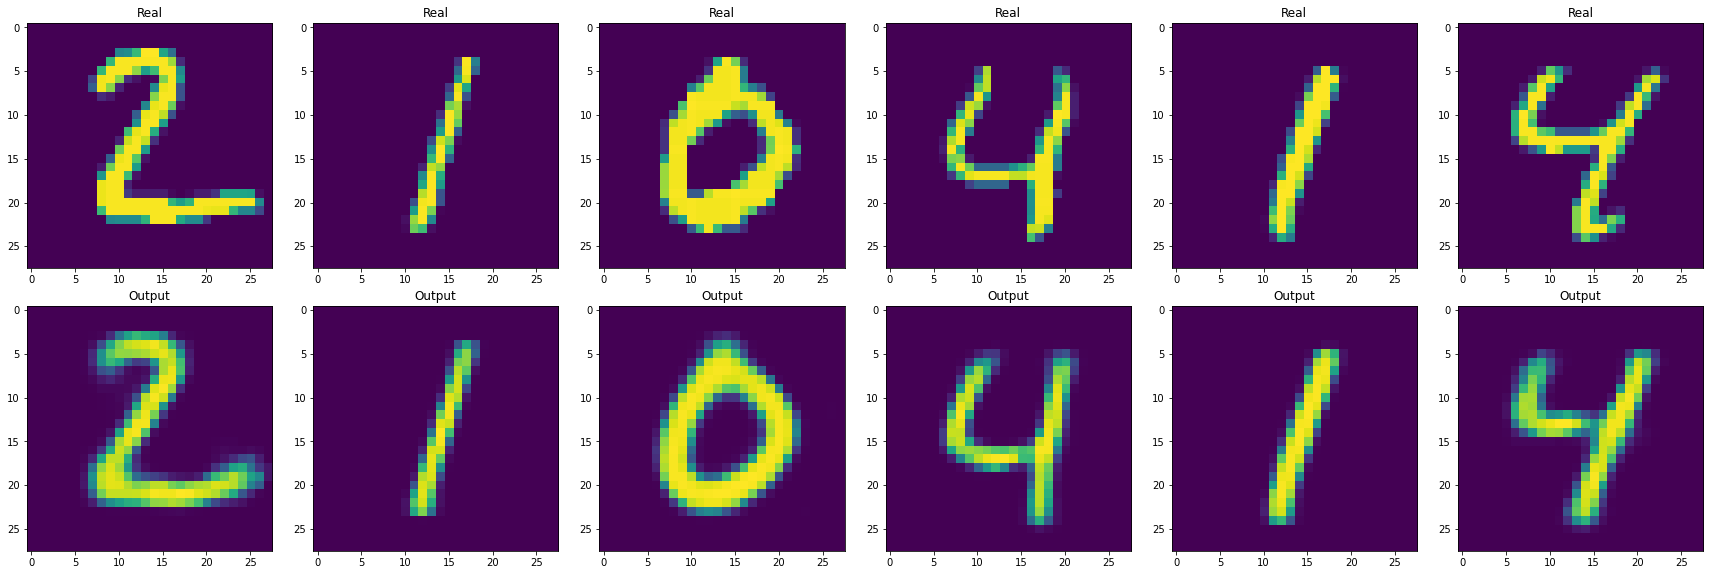

epoch: 100%|██████████| 20/20 [04:45<00:00, 14.29s/it]


In [20]:
torch.cuda.empty_cache()
CVAE = CVAE_v1().to(DEVICE)
criterion = loss_vae
optimizer = optim.Adam(CVAE.parameters(), lr=1e-3)

history = train(train_loader, test_loader, model=CVAE, epochs=20, opt=optimizer, criterion=criterion)

### Sampling


In [27]:
# Рисуем единички
z = np.array([np.random.normal(0, 1, 20) for i in range(32)])
z = torch.tensor(z).float().to(DEVICE)
class_num = torch.ones((32)).to(DEVICE)

CVAE.eval()
output = CVAE.decode(z, class_num)
output = output[:, 0:output.shape[1]-10]
output = output.view(32,28,28)
output = output.detach().cpu().numpy()

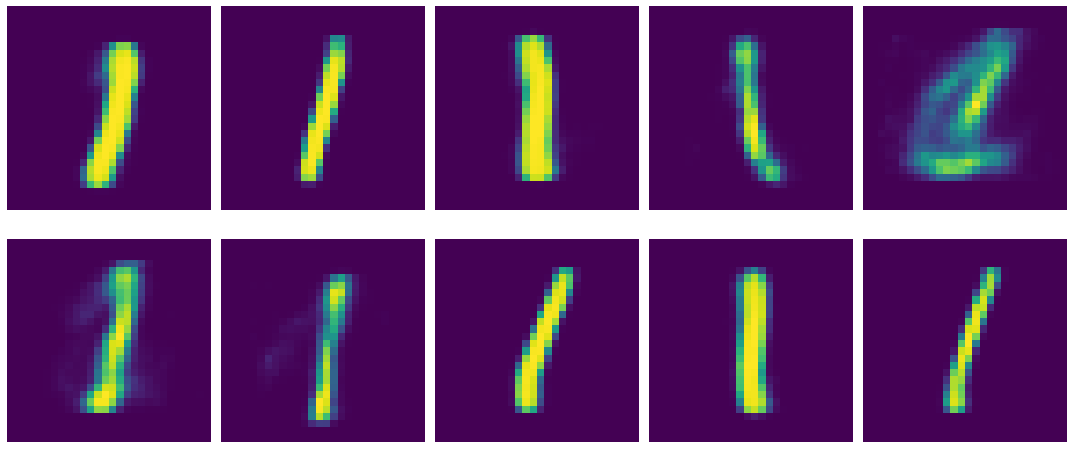

In [28]:
number = 0
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
for i in range(0,2):
    for j in range(0,5):
        axes[i][j].imshow(output[number])
        number += 1
        axes[i][j].axis("off")
plt.tight_layout()

plt.show()

### Latent Representations

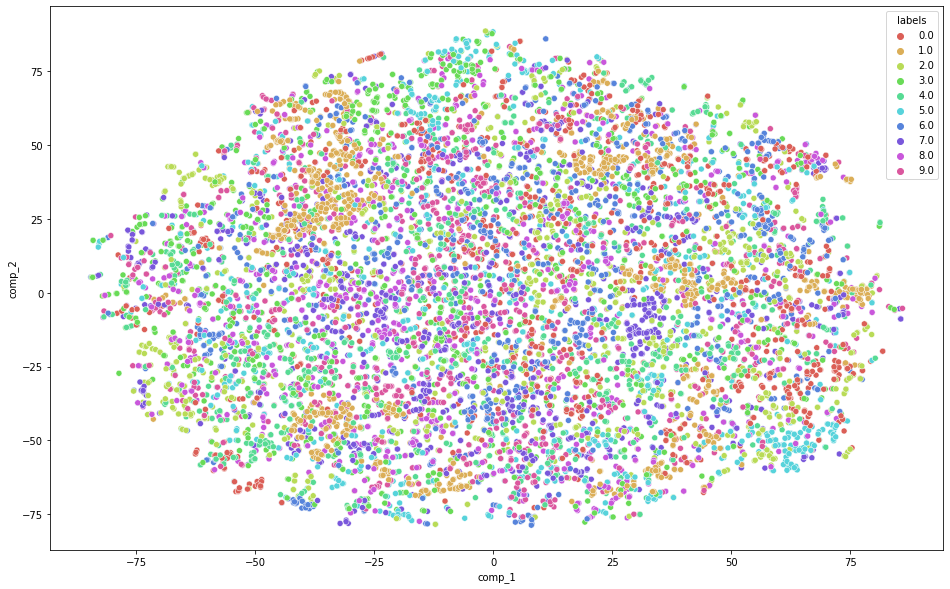

In [30]:
# Кластеры перестали быть визуально разделимы
mu_concat = np.ones(shape=(0,20))
labels_list = np.array([])

for input, labels in test_loader:
    labels_list = np.append(labels_list, labels)
    input = input.to(DEVICE)
    labels = labels.to(DEVICE)
    CVAE.eval()
    with torch.no_grad():
        mu, sigma = CVAE.encode(input.view(-1, 784), labels)
        mu_concat = np.concatenate([mu_concat, mu.cpu().numpy()])


X_embedded = TSNE(n_components=2).fit_transform(mu_concat)
X_embedded = np.hstack([X_embedded,labels_list.reshape(-1,1)])
df = pd.DataFrame(data=X_embedded, columns=["comp_1", "comp_2", "labels"])


plt.figure(figsize=(16,10))
sns.scatterplot(
    x="comp_1", y="comp_2",
    hue="labels",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
)
plt.show()